# **--- Estimate the Functional Connectivity (FC) ---**
---

In this tutorial, we're going to go through the following points :
1. Estimation of the undirected static and dynamic FC
1. Estimation of the directed static and dynamic FC

In [14]:
import os

import numpy as np
import scipy
import xarray as xr
import pandas as pd

from frites.conn import (conn_dfc, conn_covgc, conn_reshape_undirected,
                         conn_reshape_directed, define_windows, plot_windows,
                         conn_ravel_directed)

import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

plt.style.use('seaborn-dark')
plt.style.use('seaborn-poster')

%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
# **--- ROOT PATH ---**

<div class="alert alert-info"><p>

Define the path to where the data are located !
</p></div>

In [2]:
ROOT = '/Users/benitezandonea2/CookingFrites/dataset/'

---
# **0 - Functions**

In [3]:
###############################################################################
###############################################################################
#                 Load the data of a single subject
###############################################################################
###############################################################################

def load_ss(subject_nb):
    """Load the data of a single subject.
    
    Parameters
    ----------
    subject_nb : int
        Subject number [0, 12]
    
    Returns
    -------
    hga : xarray.DataArray
        Xarray containing the high-gamma activity
    anat : pandas.DataFrame
        Table containing the anatomical informations
    beh : pandas.DataFrame
        Table containing the behavioral informations
    """
    # load the high-gamma activity
    file_hga = os.path.join(ROOT, 'hga', f'hga_s-{subject_nb}.nc')
    hga = xr.load_dataarray(file_hga)

    # load the name of the brain regions
    file_anat = os.path.join(ROOT, 'anat', f'anat_s-{subject_nb}.xlsx')
    anat = pd.read_excel(file_anat)

    # load the behavior
    file_beh = os.path.join(ROOT, 'beh', f'beh_s-{subject_nb}.xlsx')
    beh = pd.read_excel(file_beh)
    
    # simplify channel names (keep only the first contact name)
    hga['channels'] = [c.split('-')[0] for c in hga['channels'].data]
    
    return hga, anat, beh


###############################################################################
###############################################################################
#                 Load the data of multiple subjects
###############################################################################
###############################################################################

def load_ms(s_range=[0, 11], model='outcome', condition='rew',
            space='channels', mean_roi=True, prepend_suj_to_ch=True):
    """Load multiple subjects.
    
    Parameters
    ----------
    s_range : int or list
        Subjects to load. Use either an integer (e.g. 7) to load a single
        subject or a range of subjects (e.g. [5, 10])
    model : {'outcome', 'pe', 'rt'}
        Model to use. Use either :
        
            * 'outcome' : find differences in the neural activity between the
              outcomes
            * 'pe' : find regions with an activity correlating with the
              prediction error
            * 'rt' : find regions with an activity correlating with the
              reaction time
    condition : {'rew', 'pun', 'context', 'null'}
        Condition to load. Use either :
        
            * 'rew' : for outcomes {+0€; +1€}
            * 'pun' : for outcomes {-1€; -0€}
            * 'context' : for outcomes {-1€; +1€}
            * 'null' : for outcomes {-0€; +0€}
    space : {'channels', 'roi'}
        Specify if the spatial dimension should be described with channel names
        or with brain region names
    mean_roi : bool
        Specify if you want to take the mean high-gamma activity inside a brain
        region
    prepend_suj_to_ch : bool
        Add subject name to each channel name
    
    Returns
    -------
    hga : list
        List of high-gamma activity across subjects
    """
    # inputs checking
    if isinstance(s_range, int):
        s_range = [s_range, s_range]
    s_range[1] += 1
    s_range[0], s_range[1] = max(s_range[0], 0), min(s_range[1], 12)
    mesg = f"Subject %i | model={model} | condition={condition} | space={space}"
    pbar = ProgressBar(range(s_range[0], s_range[1]), mesg=mesg % 0)
    model = model.lower()
    assert space in ['channels', 'parcels', 'roi']
    
    # get the code of the condition
    outc = {
        'rew': (+1, +2),
        'pun': (-2, -1),
        'context': (-2, +2),
        'null': (-1, +1)
    }[condition]
    
    # get the behavioral column to use
    col = {
        'outcome': 'code',
        'pe': 'PE',
        'rt': 'RT'
    }[model]
    
    # load the data
    hga = []
    for n_s in range(s_range[0], s_range[1]):
        pbar._tqdm.desc = mesg % n_s
        # load the data of a single subject
        _hga, _anat, _beh = load_ss(n_s)
        _outc = _hga['trials'].data
        _ch = _hga['channels'].data
        
        # replace trial dimension with the model
        _hga = _hga.rename(trials=model)
        _hga[model] = list(_beh[col])
        
        # get which outcome to keep
        keep_outc = np.logical_or(_outc == outc[0], _outc == outc[1])
        _hga = _hga[keep_outc, ...]
        
        # replace with brain regions
        if space in ['parcels', 'roi']:
            _hga = _hga.rename(channels=space)
            _hga[space] = list(_anat['roi'])
            
            # take the mean of the hga per parcel
            if mean_roi:
                _hga = _hga.groupby(space).mean(space)
        elif prepend_suj_to_ch and (space == 'channels'):
            # prepend subject number to channel name
            _hga['channels'] = [f"suj{n_s}/{c}" for c in _ch]
        
        # ascontinuous array
        _hga.data = np.ascontiguousarray(_hga.data)
        
        hga.append(_hga)
        pbar.update_with_increment_value(1)

    return hga


###############################################################################
###############################################################################
#                           Plotting the results
###############################################################################
###############################################################################

def plot_conn(conn, figsize=(13, 10), cmap='Spectral_r', interactive=False):
    """Plot the connectivity array.
    
    Parameters
    ----------
    conn : xr.DataArray
        Output of a function to estimate the FC
    figsize : tuple
        Figure size
    cmap : string
        Colormap
    """
    # get if the connectivity array is directed or not
    if 'type' in conn.attrs.keys():
        directed = conn.attrs['type'] != 'dfc'
    else:
        directed = False
    
    # split between dynamic interactive or static
    if interactive:
        if directed:
            conn = conn_ravel_directed(conn.copy())

        @interact(roi=conn['roi'].data, demean=True, conn=fixed(conn))
        def plot(conn=None, roi=conn['roi'].data[0], demean=True):
            sub_times = conn['times'].data
            roi_idx = conn['roi'].data.tolist().index(roi)

            # compute confidence interval across trials
            confidence = 0.95
            n = len(conn['trials'])
            m = conn.mean('trials').data
            se = scipy.stats.sem(conn.data, axis=0)
            h = se * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
            clow, chigh = m - h, m + h
            conn_m = conn.mean('trials')
            
            # data detrending
            if demean:
                cmin = conn_m.min('times', keepdims=True)
                conn_m.data -= cmin.data
                clow -= cmin.data
                chigh -= cmin.data
            else:
                pass

            cmin, cmax = clow.min(), chigh.max()
            dp = (cmax - cmin) / 20
            plt.plot(sub_times, conn_m.sel(roi=roi))
            plt.grid(True)
            plt.axvline(0., color='k', linestyle='--')
            plt.ylim(cmin - dp, cmax + dp)
            plt.xlim(sub_times[0], sub_times[-1])
            plt.fill_between(sub_times, clow[roi_idx, :], chigh[roi_idx, :],
                             alpha=.1)
    else:
        # average across the trial dimension
        conn = conn.mean('trials')

        if len(conn['times']) == 1:
            if not directed:
                df = conn_reshape_undirected(conn).squeeze().to_pandas()
            else:
                df = conn_reshape_directed(conn).squeeze().to_pandas()
        else:
            df = conn.to_pandas()

        vmin = np.nanpercentile(df.values, 1)
        vmax = np.nanpercentile(df.values, 99)

        plt.figure(figsize=figsize)
        plt.imshow(df.values, cmap=cmap, vmin=vmin, vmax=vmax)
        ax = plt.gca()
        ax.set_xticks(np.arange(len(df.columns)))
        ax.set_yticks(np.arange(len(df.index)))
        ax.set_xticklabels(df.columns)
        ax.set_yticklabels(df.index)
        plt.colorbar()
        if directed:
            plt.xlabel('Targets'), plt.ylabel('Sources')


# **1. Undirected FC**
## 1.1 Undirecteda and static, FC
### 1.1.1 Selecting a period of interest

In [4]:
from frites_connectivity_tutorial.load_data import load_dataset

In [7]:
dataPath = '/Users/benitezandonea2/Documents/MEG_Hackathon/frites_dset'
hga_all = load_dataset(dataPath)

Reading /Users/benitezandonea2/Documents/MEG_Hackathon/frites_dset/ON61373_epo.fif ...
    Reading extended channel information
Isotrak not found
    Found the data of interest:
        t =    -600.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/benitezandonea2/Documents/MEG_Hackathon/frites_dset/ON21976_epo.fif ...
    Reading extended channel information
Isotrak not found
    Found the data of interest:
        t =    -600.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/benitezandonea2/Documents/MEG_Hackathon/frites_dset/ON42107_epo.fif ...
    Reading extended channel information
Isotrak not found
    Found the data of interest:
        t =    -600.00 ...    1000.00 ms
        0 CTF compensation matrices ava

    Reading extended channel information
Isotrak not found
    Found the data of interest:
        t =    -600.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/benitezandonea2/Documents/MEG_Hackathon/frites_dset/ON70467_epo.fif ...
    Reading extended channel information
Isotrak not found
    Found the data of interest:
        t =    -600.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/benitezandonea2/Documents/MEG_Hackathon/frites_dset/ON49080_epo.fif ...
    Reading extended channel information
Isotrak not found
    Found the data of interest:
        t =    -600.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
80 matching events found
No baseline correction applied
0 p

Definition of an electrophysiological dataset
    Dataset composed of 38 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)


In [11]:
hga_all.x[0].data *= 1e12


<IPython.core.display.Javascript object>


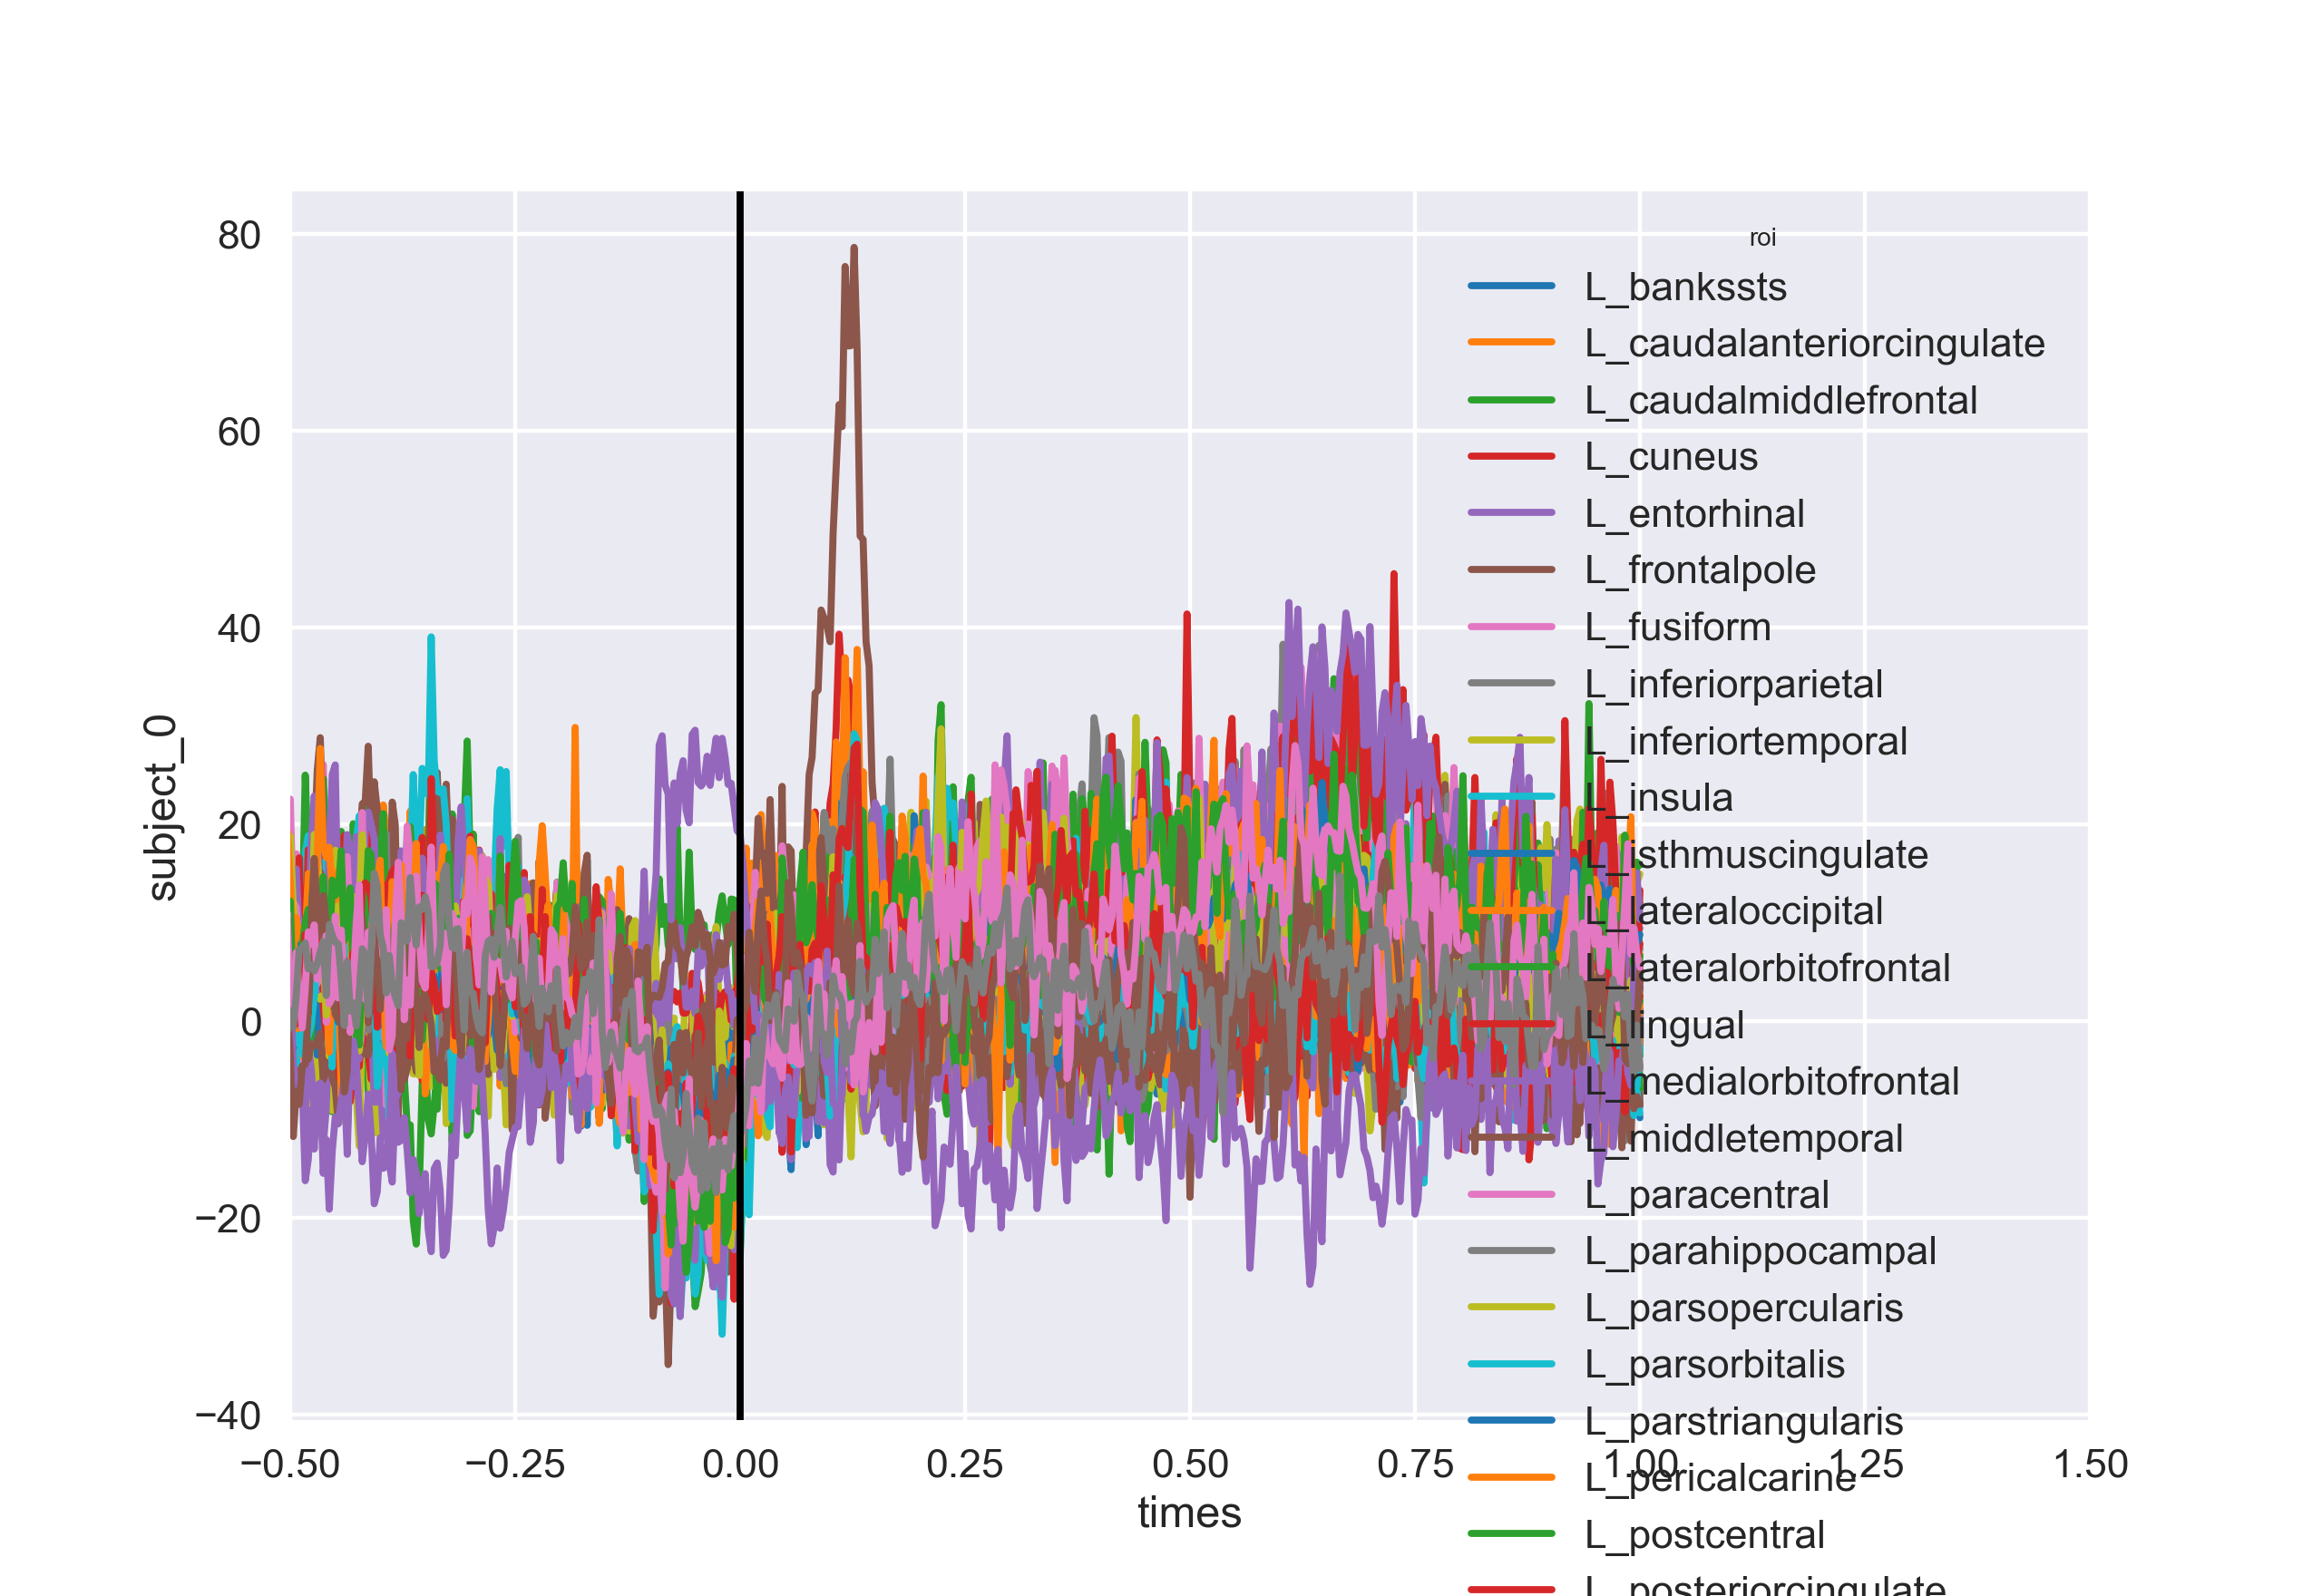

(-0.5, 1.5)

In [15]:
# load the data of a single subject
hga = hga_all.x[0]#load_ss(7)[0]

# plot the data of the subject
_t = hga['times'].sel(times=slice(0., 0.75)).data
hga.mean('trials').plot(x='times', hue ='roi')#hue='channels')
plt.grid(True);
plt.axvline(0., color='k');
plt.fill_between(_t, np.full((len(_t),), -.2), np.full((len(_t),), 1.5),
                 color='red', alpha=.1)
plt.xlim(-.5, 1.5)#, plt.ylim(-.2, 1.5);

In [28]:
conn_dfc?

### 1.1.2 Compute the FC

In [17]:
# select the data during the period in red
hga_poi = hga.sel(times=slice(0., .75)) # sternberg task

# compute the functional connectivity (amplitude correlation)
conn_us = conn_dfc(hga_poi,roi='roi', times='times')# roi='channels', times='times')

conn_us

Defining links (n_roi=68; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=False, demeaned=False)
Computing DFC between 2278 pairs (gcrn=False)


  0%|          | Estimating DFC : 0/2278 [00:00<?,       ?it/s]

<xarray.DataArray 'DFC (Gaussian Copula Mutual Information Estimator)' (
                                                                        trials: 80,
                                                                        roi: 2278,
                                                                        times: 1)>
array([[[1.57670490e-03],
        [2.26961225e-02],
        [4.70797671e-03],
        ...,
        [6.82062097e-03],
        [1.16686054e-01],
        [2.92400476e-02]],

       [[2.42063170e-03],
        [9.27091483e-03],
        [3.35966749e-03],
        ...,
        [3.30435932e-02],
        [1.18667960e-01],
        [2.43510246e-01]],

       [[5.03386371e-04],
        [4.53383254e-05],
        [5.30385470e-04],
        ...,
...
        ...,
        [4.39900951e-03],
        [8.51745605e-02],
        [5.94168762e-03]],

       [[1.89582091e-02],
        [1.59428846e-02],
        [1.93003565e-03],
        ...,
        [3.13973683e-03],
        [6.93714097e-02],
        [1.25897219e-02]],

       [[3.26046866e-04],
        [3.95168870e-04],
        [1.23654830e-03],
        ...,
        [1.84381695e-03],
        [4.52689491e-02],
        [3.24732391e-04]]])
Coordinates:
  * trials   (trials) int64 0 1 2 3 4 5 6 7 8 9 ... 71 72 73 74 75 76 77 78 79
  * roi      (roi) <U53 'L_bankssts-L_caudalanteriorcingulate' ... 'R_tempora...
  * times    (times) float64 0.375
Attributes:
    win_sample:    [  0 225]
    win_times:     [0.375]
    agg_ch:        1
    type:          dfc
    estimator:     Gaussian Copula Mutual Information Estimator
    __version__:   0.4.2
    modality:      electrophysiology
    dtype:         SubjectEphy
    y_dtype:       int
    z_dtype:       none
    mi_type:       cd
    mi_repr:       I(x; y (discret))
    sfreq:         300.000000000003
    multivariate:  0
    sources:       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
    targets:       [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...

### 1.1.3 Connectivity array reshaping

In [18]:
conn_rsh = conn_reshape_undirected(
    conn_us.mean('trials'), 
)
conn_rsh

<xarray.DataArray 'DFC (Gaussian Copula Mutual Information Estimator)' (
                                                                        sources: 68,
                                                                        targets: 68,
                                                                        times: 1)>
array([[[       nan],
        [0.00643985],
        [0.00773598],
        ...,
        [0.00643752],
        [0.00500805],
        [0.00528385]],

       [[0.00643985],
        [       nan],
        [0.0752943 ],
        ...,
        [0.00694387],
        [0.01788412],
        [0.00914578]],

       [[0.00773598],
        [0.0752943 ],
        [       nan],
        ...,
...
        ...,
        [       nan],
        [0.00858919],
        [0.05168491]],

       [[0.00500805],
        [0.01788412],
        [0.00624725],
        ...,
        [0.00858919],
        [       nan],
        [0.01891389]],

       [[0.00528385],
        [0.00914578],
        [0.00551607],
        ...,
        [0.05168491],
        [0.01891389],
        [       nan]]])
Coordinates:
  * sources  (sources) object 'L_bankssts' ... 'R_transversetemporal'
  * targets  (targets) object 'L_bankssts' ... 'R_transversetemporal'
  * times    (times) float64 0.375

In [22]:
conn_us.shape # (n_epochs, n_pairs, n_windows)


(80, 2278, 1)

### 1.1.4 Plotting the connectivity array

<IPython.core.display.Javascript object>


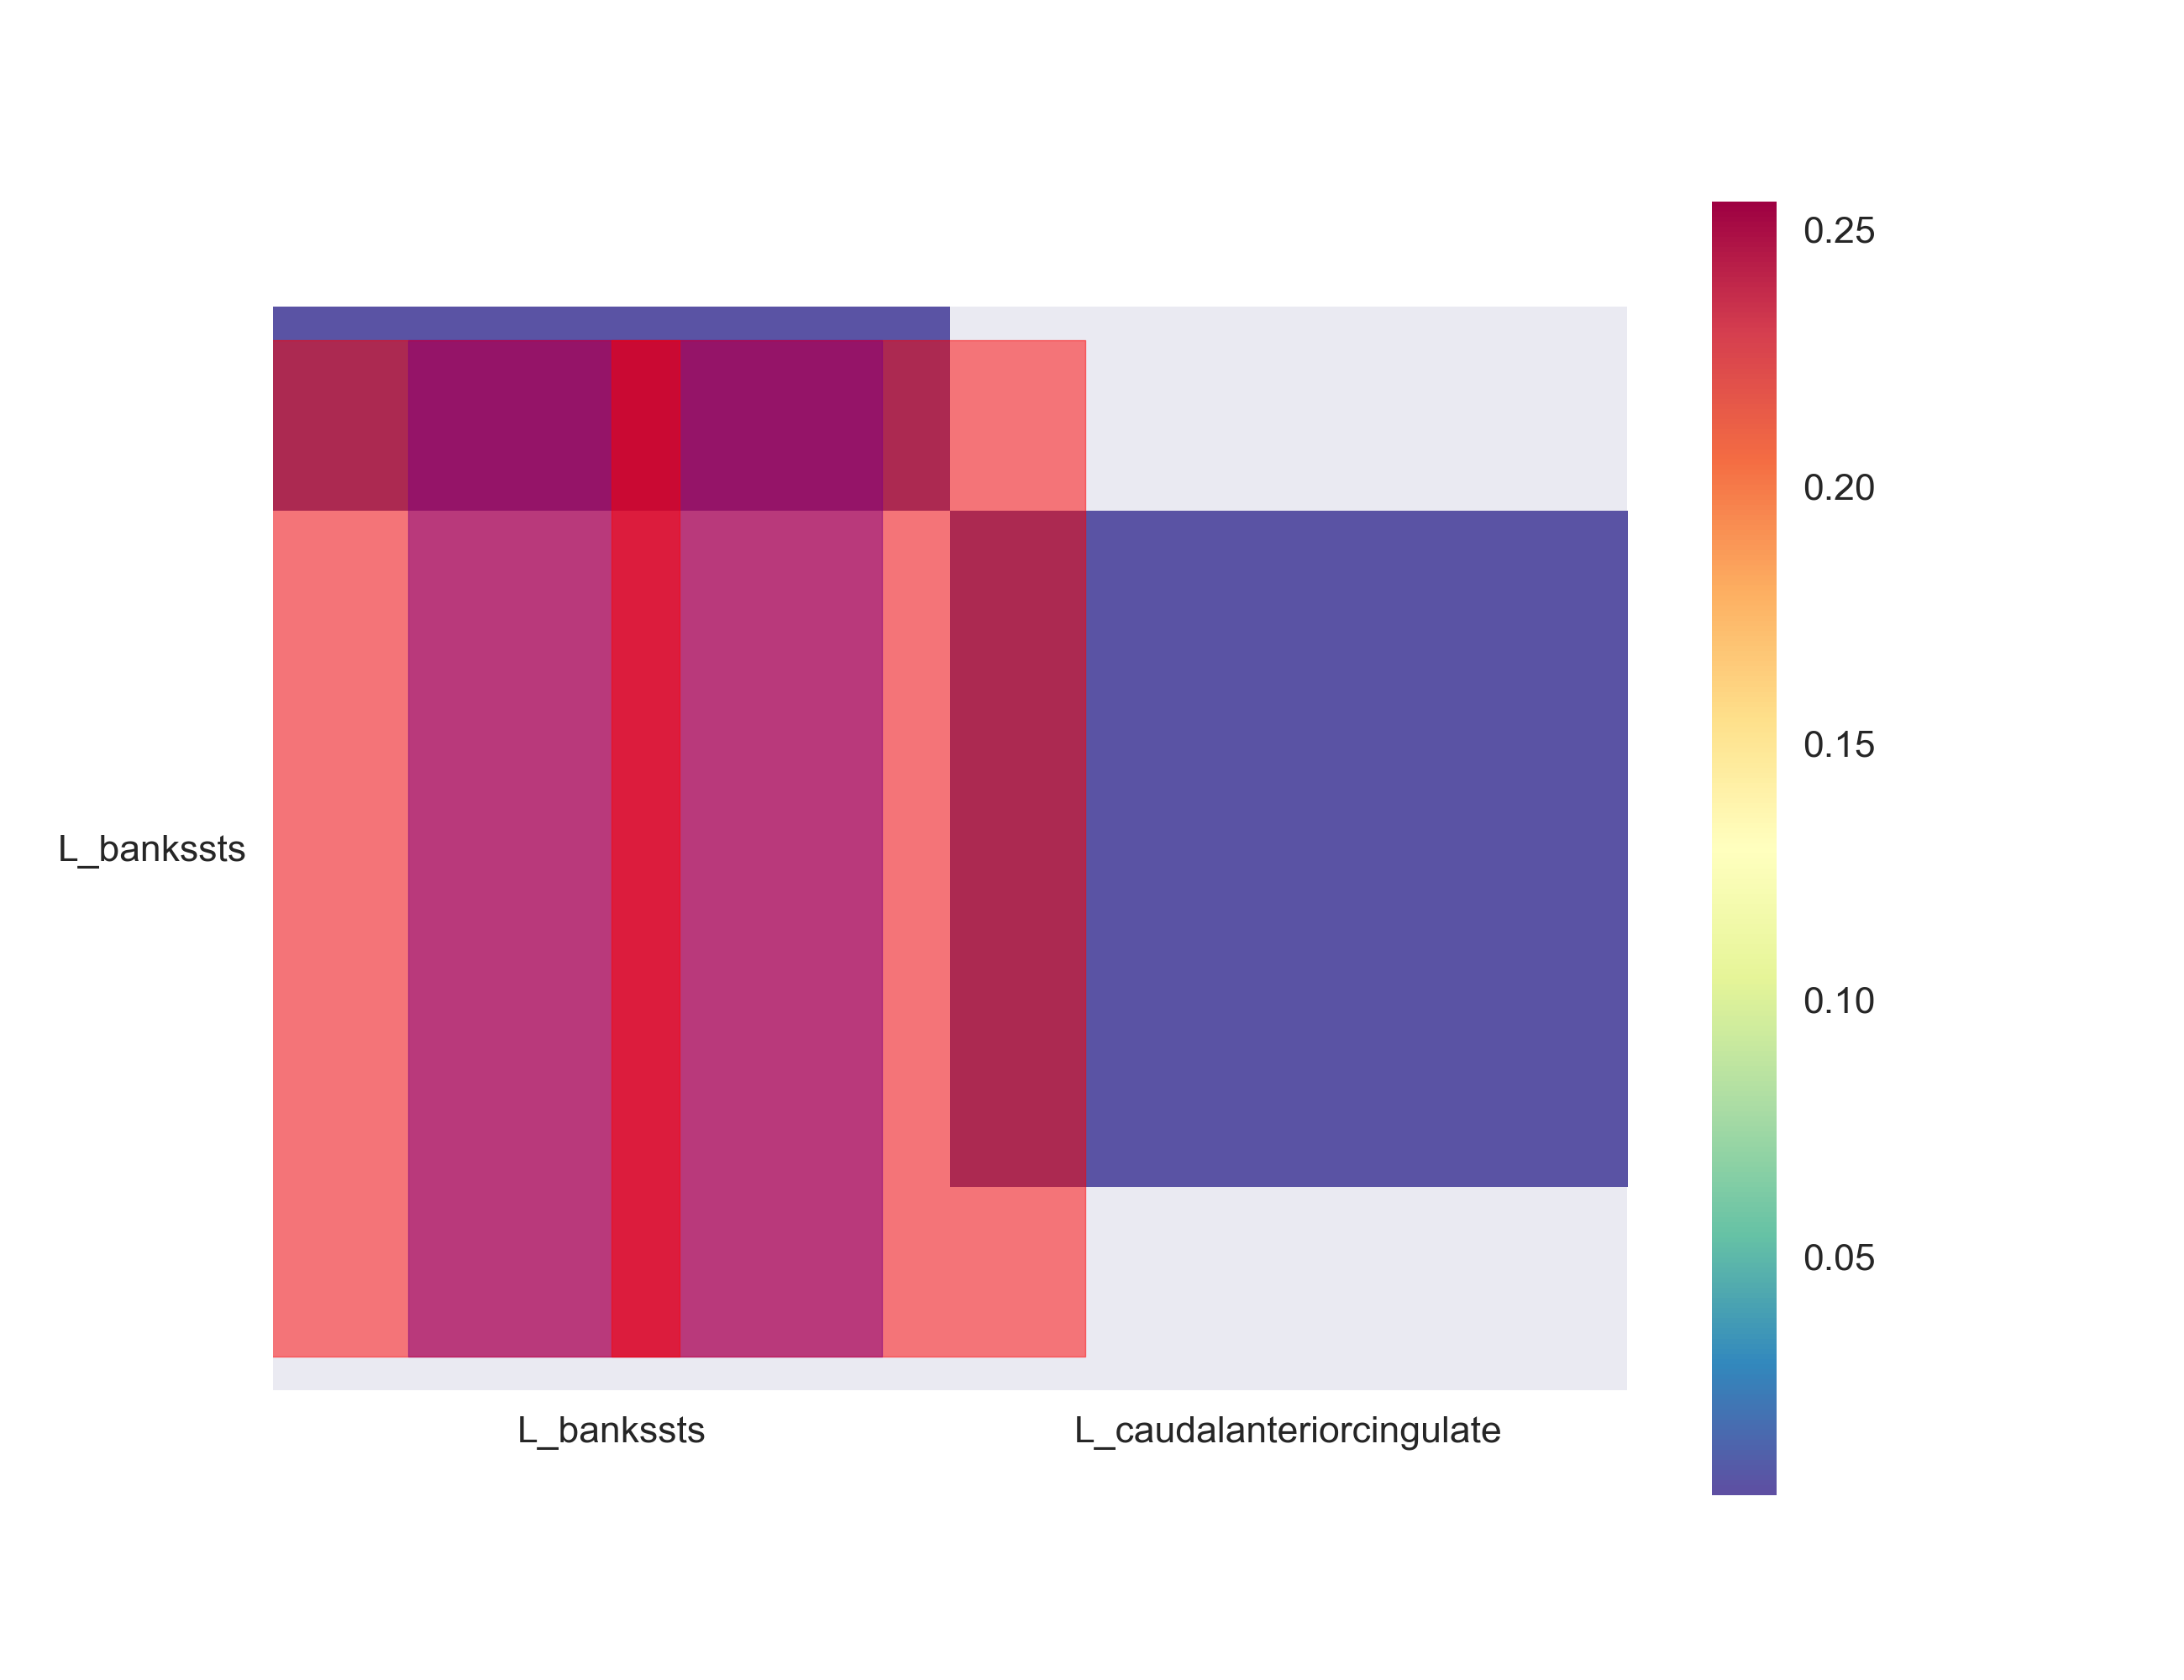

In [24]:
plot_conn(conn_us) # @@@ -- understand scale

In [33]:
hga['times'].data.shape

(481,)

## 1.2 Undirected and dynamic FC
### 1.2.1 Build sliding windows

Defining temporal windows
    Definition of sliding windows (len=0.4, start=-0.6, stop=1.0, step=0.1)
    12 windows defined


[[  0 120]
 [ 30 150]
 [ 60 180]
 [ 90 210]
 [120 240]
 [150 270]
 [180 300]
 [210 330]
 [240 360]
 [270 390]
 [300 420]
 [330 450]]


<IPython.core.display.Javascript object>


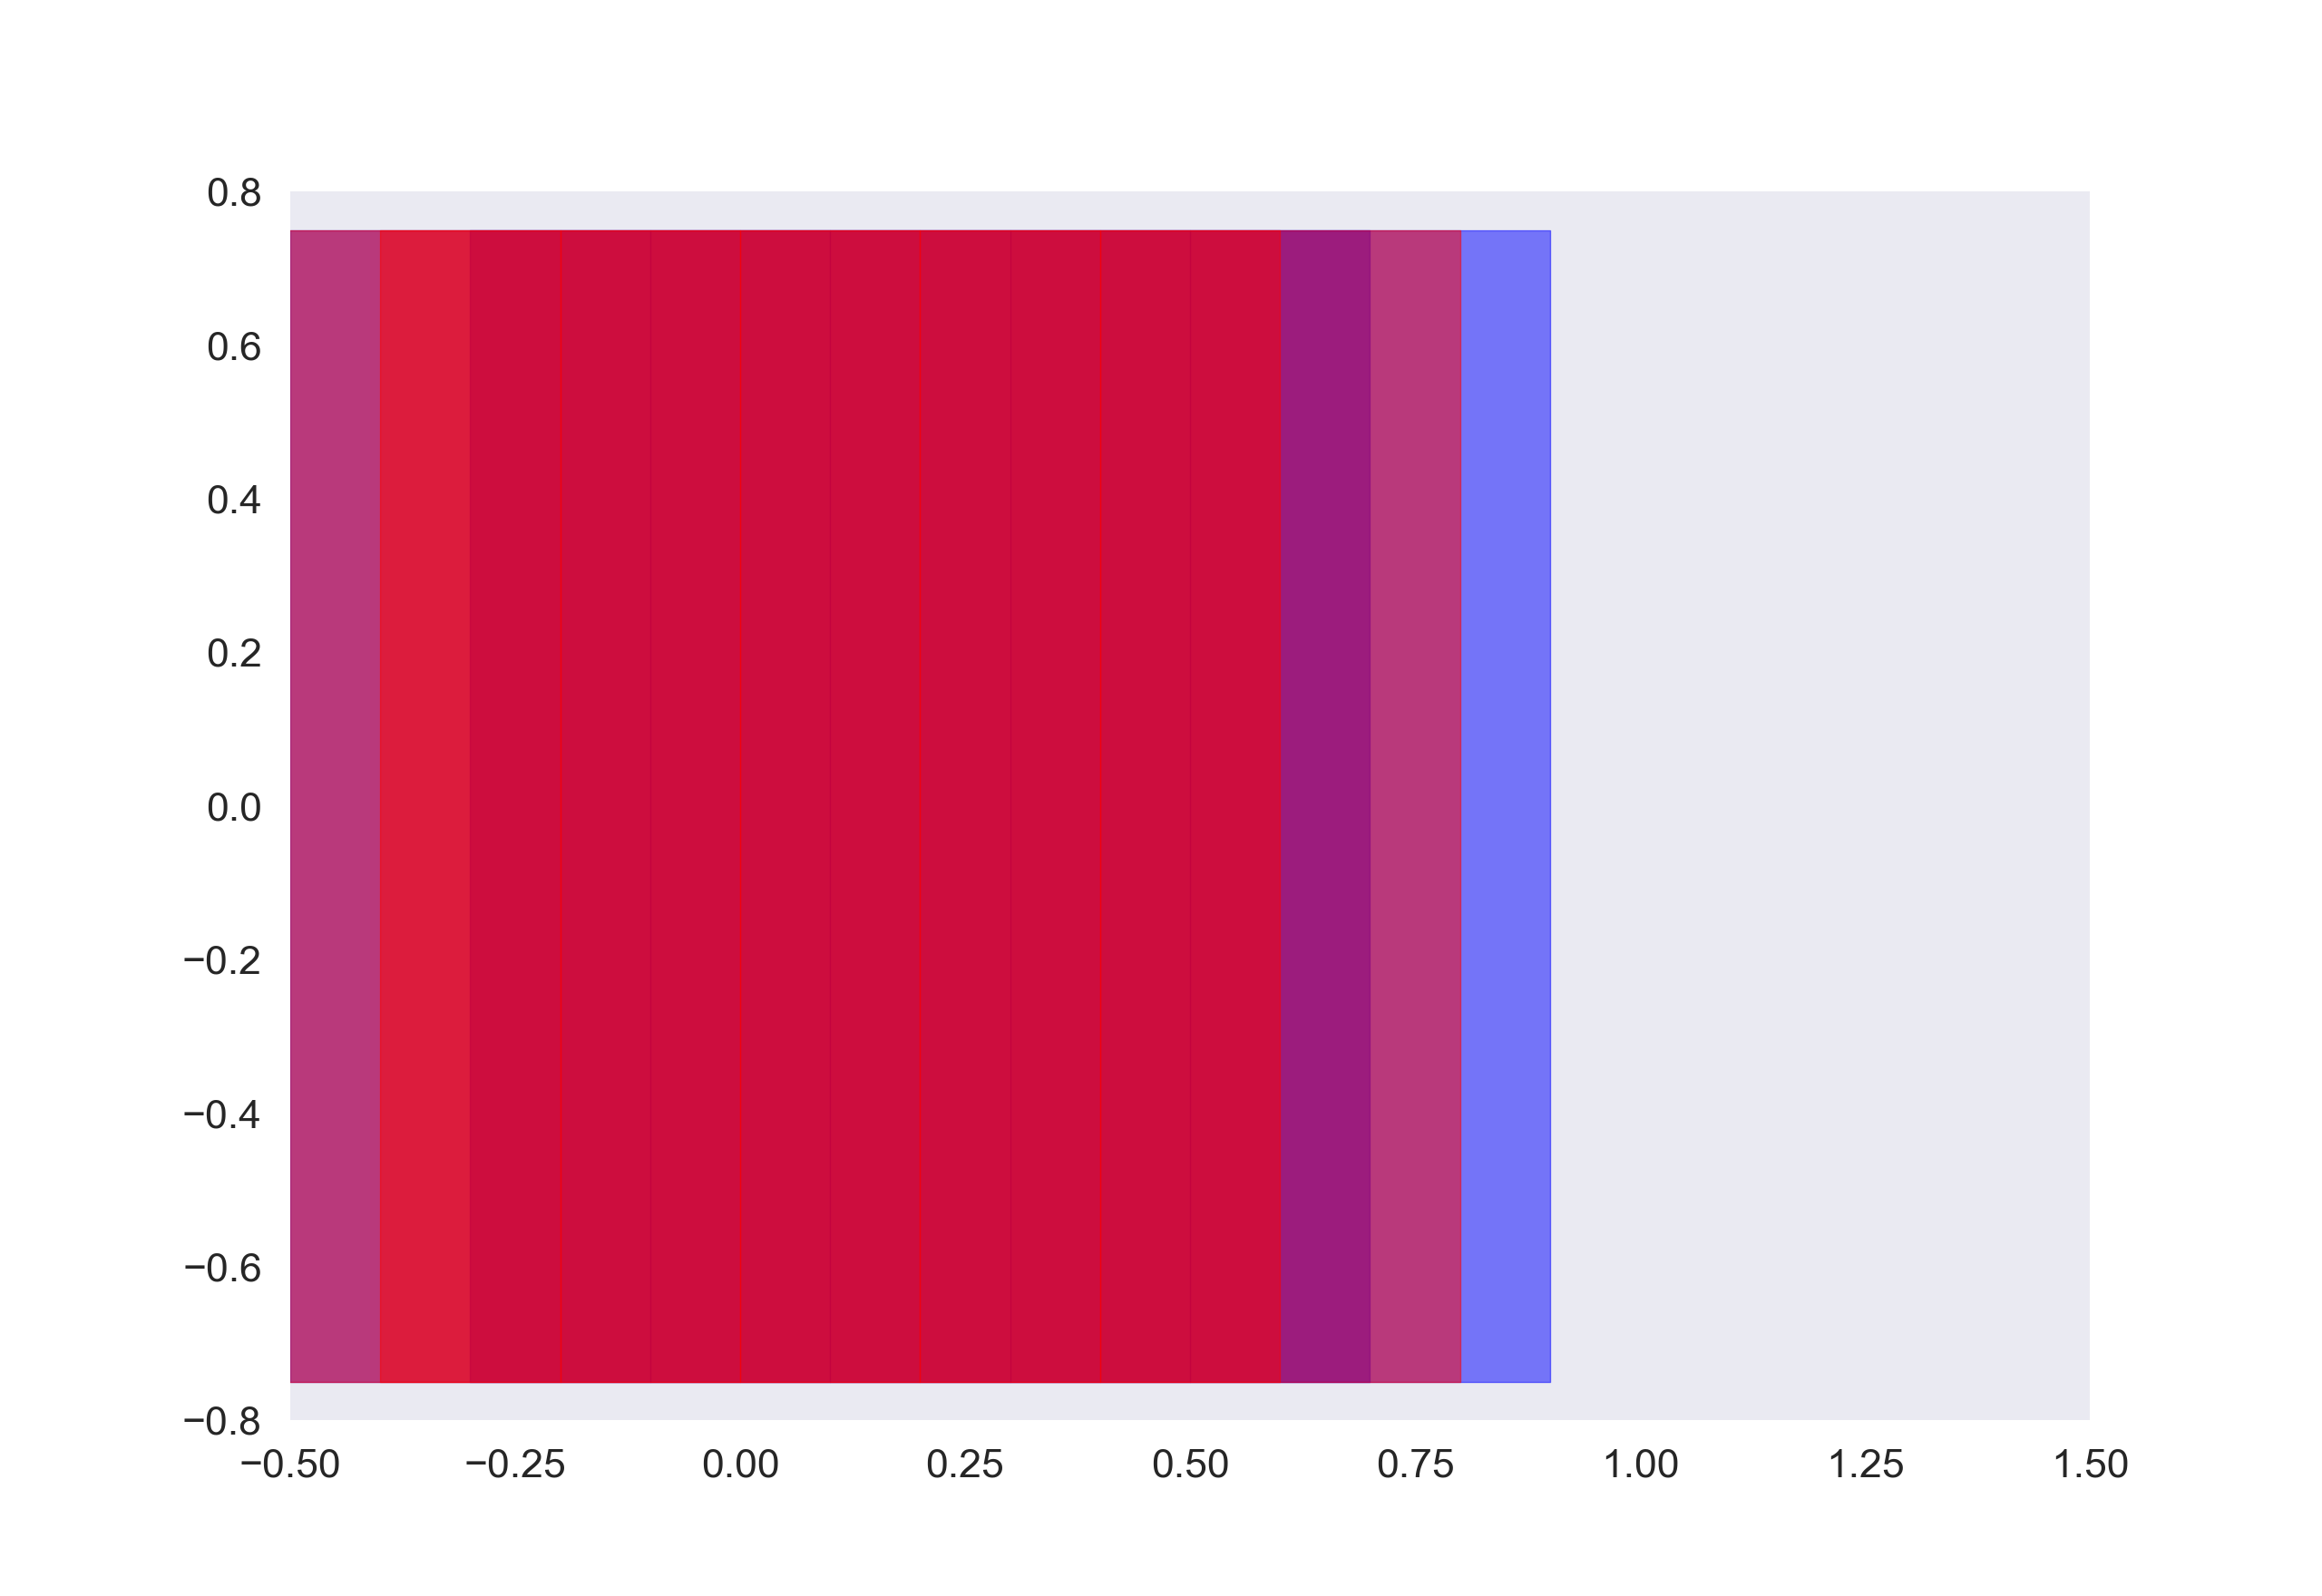

In [170]:
###############################################################################
win_len = .4   # windows of length 750ms
win_step = .1  # 400ms between each consecutive windows
###############################################################################

# get the time vector
times = hga['times'].data

# define sliding windows
win_sample, mean_time = define_windows(
    times, slwin_len=win_len, slwin_step=win_step
)

print(win_sample)

# plot the windows
fig, ax=plt.subplots()
plot_windows(times, win_sample)
plt.ylim(-0.8, 0.8), plt.xlim(-.5, 1.5);

### 1.2.2 Compute the FC inside the sliding windows

In [171]:
conn_ud = conn_dfc(hga, win_sample=win_sample,roi='roi', times='times' )#roi='channels', times='times')
conn_ud

Defining links (n_roi=68; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=False, demeaned=False)
Computing DFC between 2278 pairs (gcrn=False)


  0%|          | Estimating DFC : 0/2278 [00:00<?,       ?it/s]

<xarray.DataArray 'DFC (Gaussian Copula Mutual Information Estimator)' (
                                                                        trials: 80,
                                                                        roi: 2278,
                                                                        times: 12)>
array([[[3.97735013e-04, 3.43124964e-04, 1.32123136e-03, ...,
         2.18746762e-04, 4.58522147e-04, 8.02885275e-03],
        [4.44950210e-03, 1.40394107e-03, 5.37293404e-03, ...,
         5.98693732e-04, 1.21692650e-03, 1.92419931e-04],
        [1.62876640e-02, 5.54575212e-03, 2.64605536e-04, ...,
         4.41673072e-03, 2.63494346e-03, 1.84057318e-02],
        ...,
        [2.36754655e-03, 6.57853670e-03, 1.01183215e-02, ...,
         4.79698600e-03, 1.43790719e-04, 7.51842791e-03],
        [4.26924489e-02, 4.76416163e-02, 8.62798467e-02, ...,
         1.63939312e-01, 1.10901229e-01, 8.73639658e-02],
        [7.79287890e-02, 1.78877171e-02, 1.74094662e-02, ...,
         3.69232264e-03, 6.63748142e-05, 2.09265202e-02]],

       [[1.37817895e-03, 1.21682696e-03, 1.63243531e-04, ...,
         2.02163588e-03, 7.53947592e-04, 2.52715927e-05],
        [1.72956075e-04, 4.77374415e-05, 5.82165703e-05, ...,
         1.10924635e-02, 1.29208313e-02, 7.50230486e-03],
        [5.36719561e-02, 2.91128214e-02, 2.49178987e-02, ...,
         2.57378947e-02, 1.31213877e-04, 1.86617355e-04],
...
        [1.33177834e-02, 2.70468532e-03, 7.81999233e-07, ...,
         7.76539149e-04, 2.43396615e-03, 5.03728539e-03],
        [5.37107792e-03, 7.28579471e-03, 1.76654966e-03, ...,
         7.11232573e-02, 5.85433058e-02, 6.72654361e-02],
        [4.01942711e-03, 4.75378893e-03, 7.28225627e-04, ...,
         1.50849940e-02, 3.04419571e-03, 5.38481446e-03]],

       [[1.51123255e-04, 5.18555893e-03, 3.78960483e-02, ...,
         1.44734775e-04, 9.11776628e-03, 6.75787823e-03],
        [9.73839127e-03, 2.20868434e-03, 6.12449367e-04, ...,
         1.59955444e-03, 2.34758034e-02, 2.63219085e-02],
        [2.74032392e-02, 2.61896681e-02, 5.74013032e-03, ...,
         1.48375955e-04, 6.57229312e-03, 1.87983028e-06],
        ...,
        [2.41943970e-04, 1.04247974e-02, 1.72873028e-02, ...,
         1.17586239e-03, 2.26073619e-03, 1.70357302e-02],
        [4.58860683e-04, 2.72715679e-05, 3.74296983e-03, ...,
         6.51267990e-02, 4.46275026e-02, 2.97325924e-02],
        [6.97900401e-03, 8.49942619e-04, 1.27367536e-03, ...,
         5.57270087e-03, 1.27409613e-02, 7.49437790e-03]]])
Coordinates:
  * trials   (trials) int64 0 1 2 3 4 5 6 7 8 9 ... 71 72 73 74 75 76 77 78 79
  * roi      (roi) <U53 'L_bankssts-L_caudalanteriorcingulate' ... 'R_tempora...
  * times    (times) float64 -0.4 -0.3 -0.2 -0.1 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7
Attributes:
    win_sample:    [  0 120  30 150  60 180  90 210 120 240 150 270 180 300 2...
    win_times:     [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7]
    agg_ch:        1
    type:          dfc
    estimator:     Gaussian Copula Mutual Information Estimator
    __version__:   0.4.2
    modality:      electrophysiology
    dtype:         SubjectEphy
    y_dtype:       int
    z_dtype:       none
    mi_type:       cd
    mi_repr:       I(x; y (discret))
    sfreq:         300.00000000000307
    multivariate:  0
    sources:       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
    targets:       [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...

### 1.2.3 Plot the result

In [172]:
ind_max = conn_us.mean(axis=0).argmax() # find roi pair with max connectivity

ind_sorted = conn_us.mean(axis=0).argsort(axis=0)[::-1] #from max to min
ind_sorted = ind_sorted.data.flatten()
#for ii in range(10):
#    print(conn_us['roi'][ind_sorted[ii]])

#print(ind_sorted,ind_max)
#conn_us['roi'][ind]

In [173]:
# working memory network: bilateral dorsolateral & parietal areas
roiList= list(hga['roi'].data)

roiInd = [i for i in range(len(roiList)) if 'caudalmiddlefrontal' in roiList[i]]
print(roiInd)
count = -1
outList=[]
for i in conn_us.attrs['sources']:
    count +=1
    #print(i)
    if i in roiInd:        
        outList.append(conn_us['roi'][count].values.tolist())
        
        
#roiList_connus = [conn_us['roi'][i].values.tolist() for i in conn_us.attrs['sources'] if i in roiInd]
#roiBool_connus = [True if i in roiInd else False for i in conn_us.attrs['sources']]
#vals = conn_us.mean(axis=0)[roiBool_connus]
#print(roiList_connus)


[2, 36]


<IPython.core.display.Javascript object>


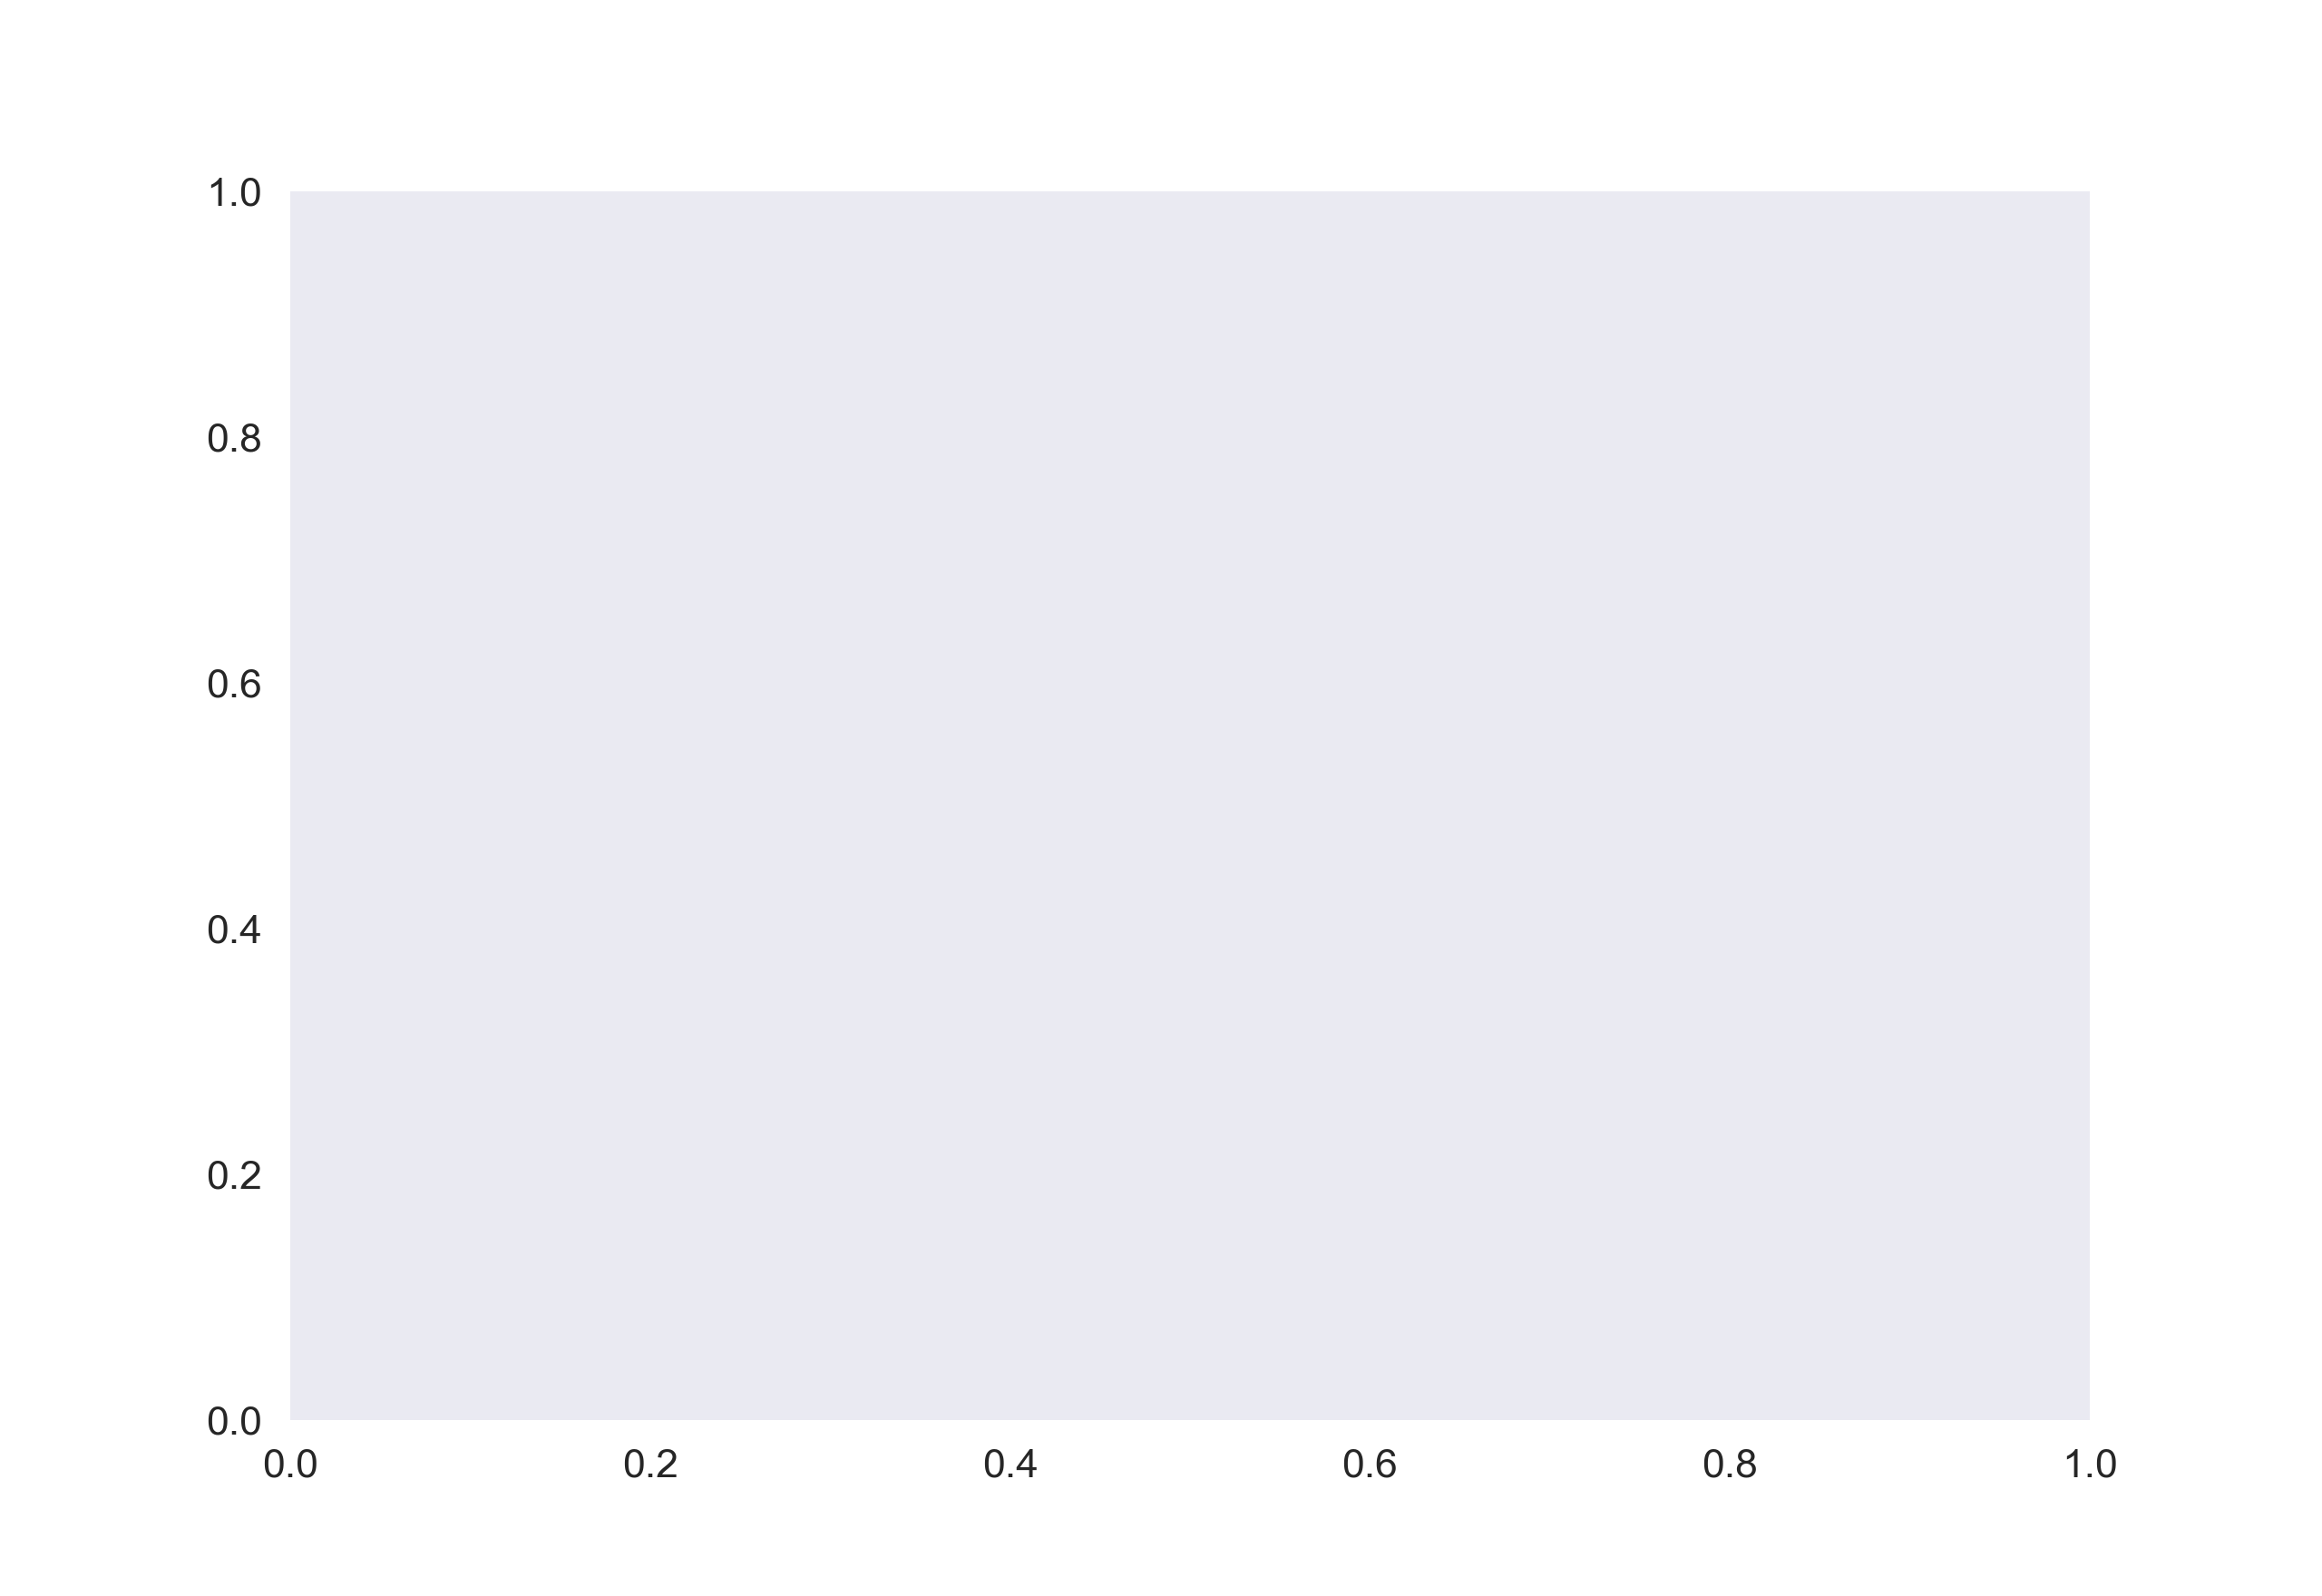

<IPython.core.display.Javascript object>


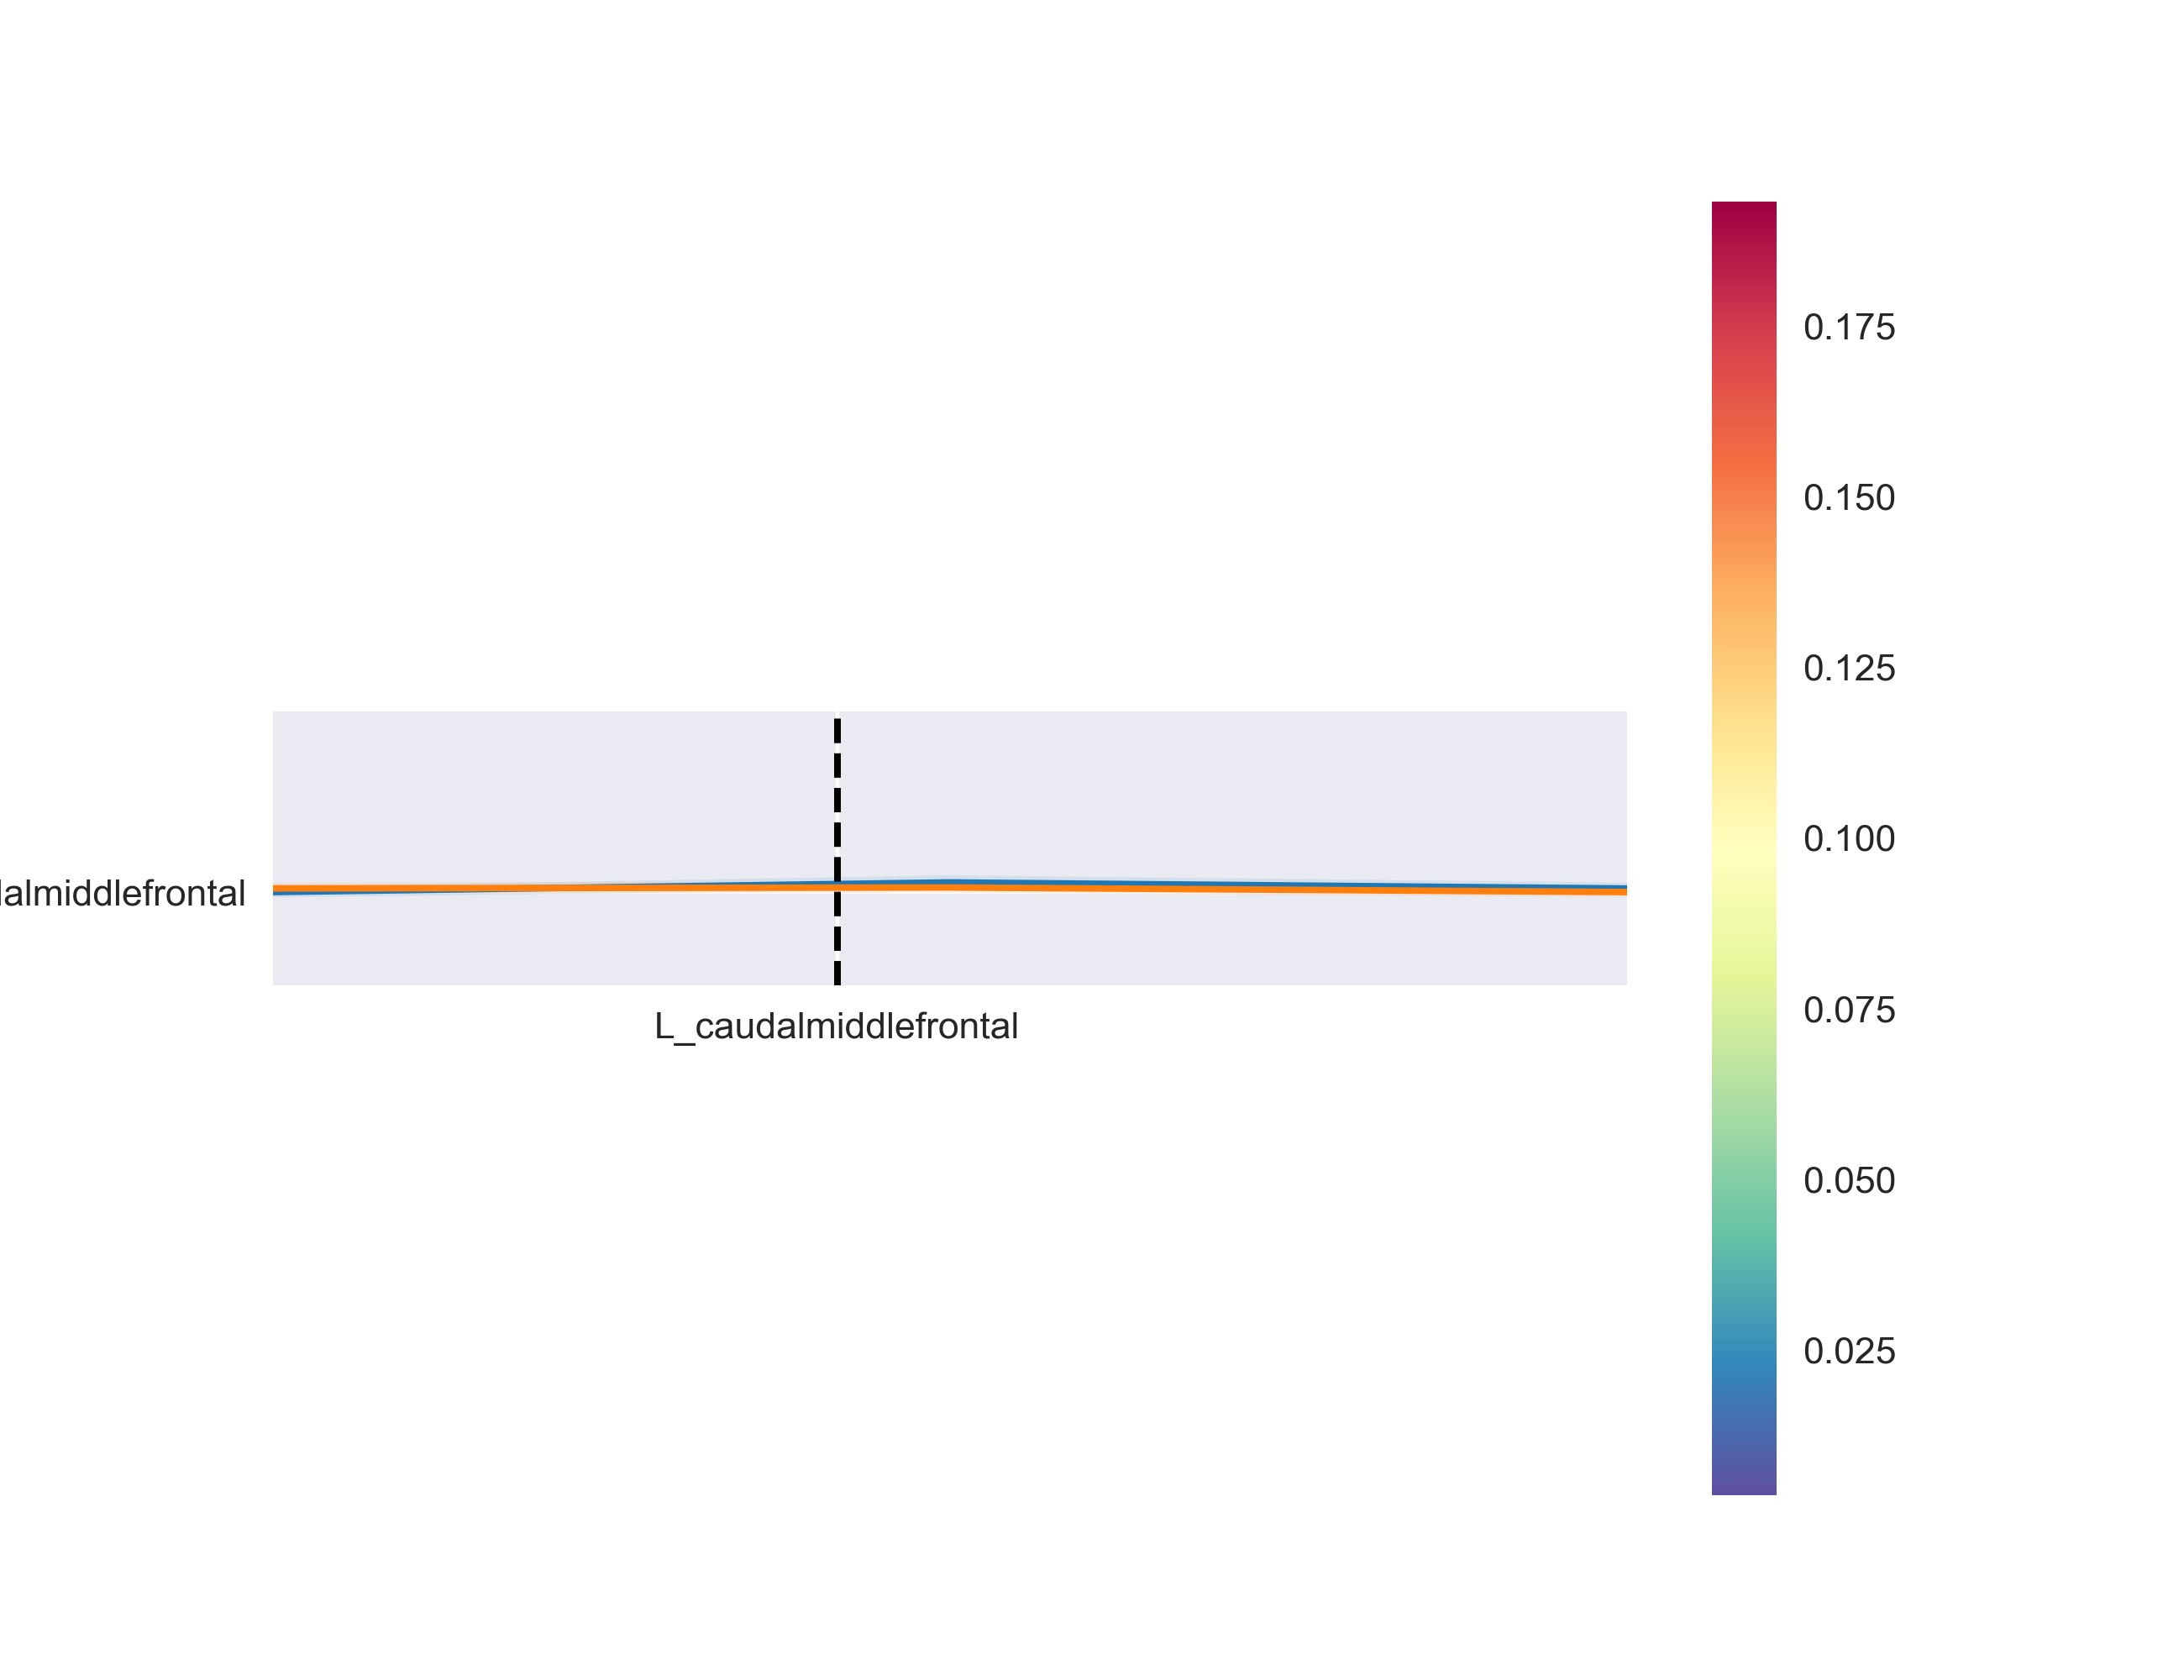

In [174]:
conn_us_subset = conn_us.sel(roi=outList)
fig, ax=plt.subplots()
plot_conn(conn_us_subset)

<IPython.core.display.Javascript object>


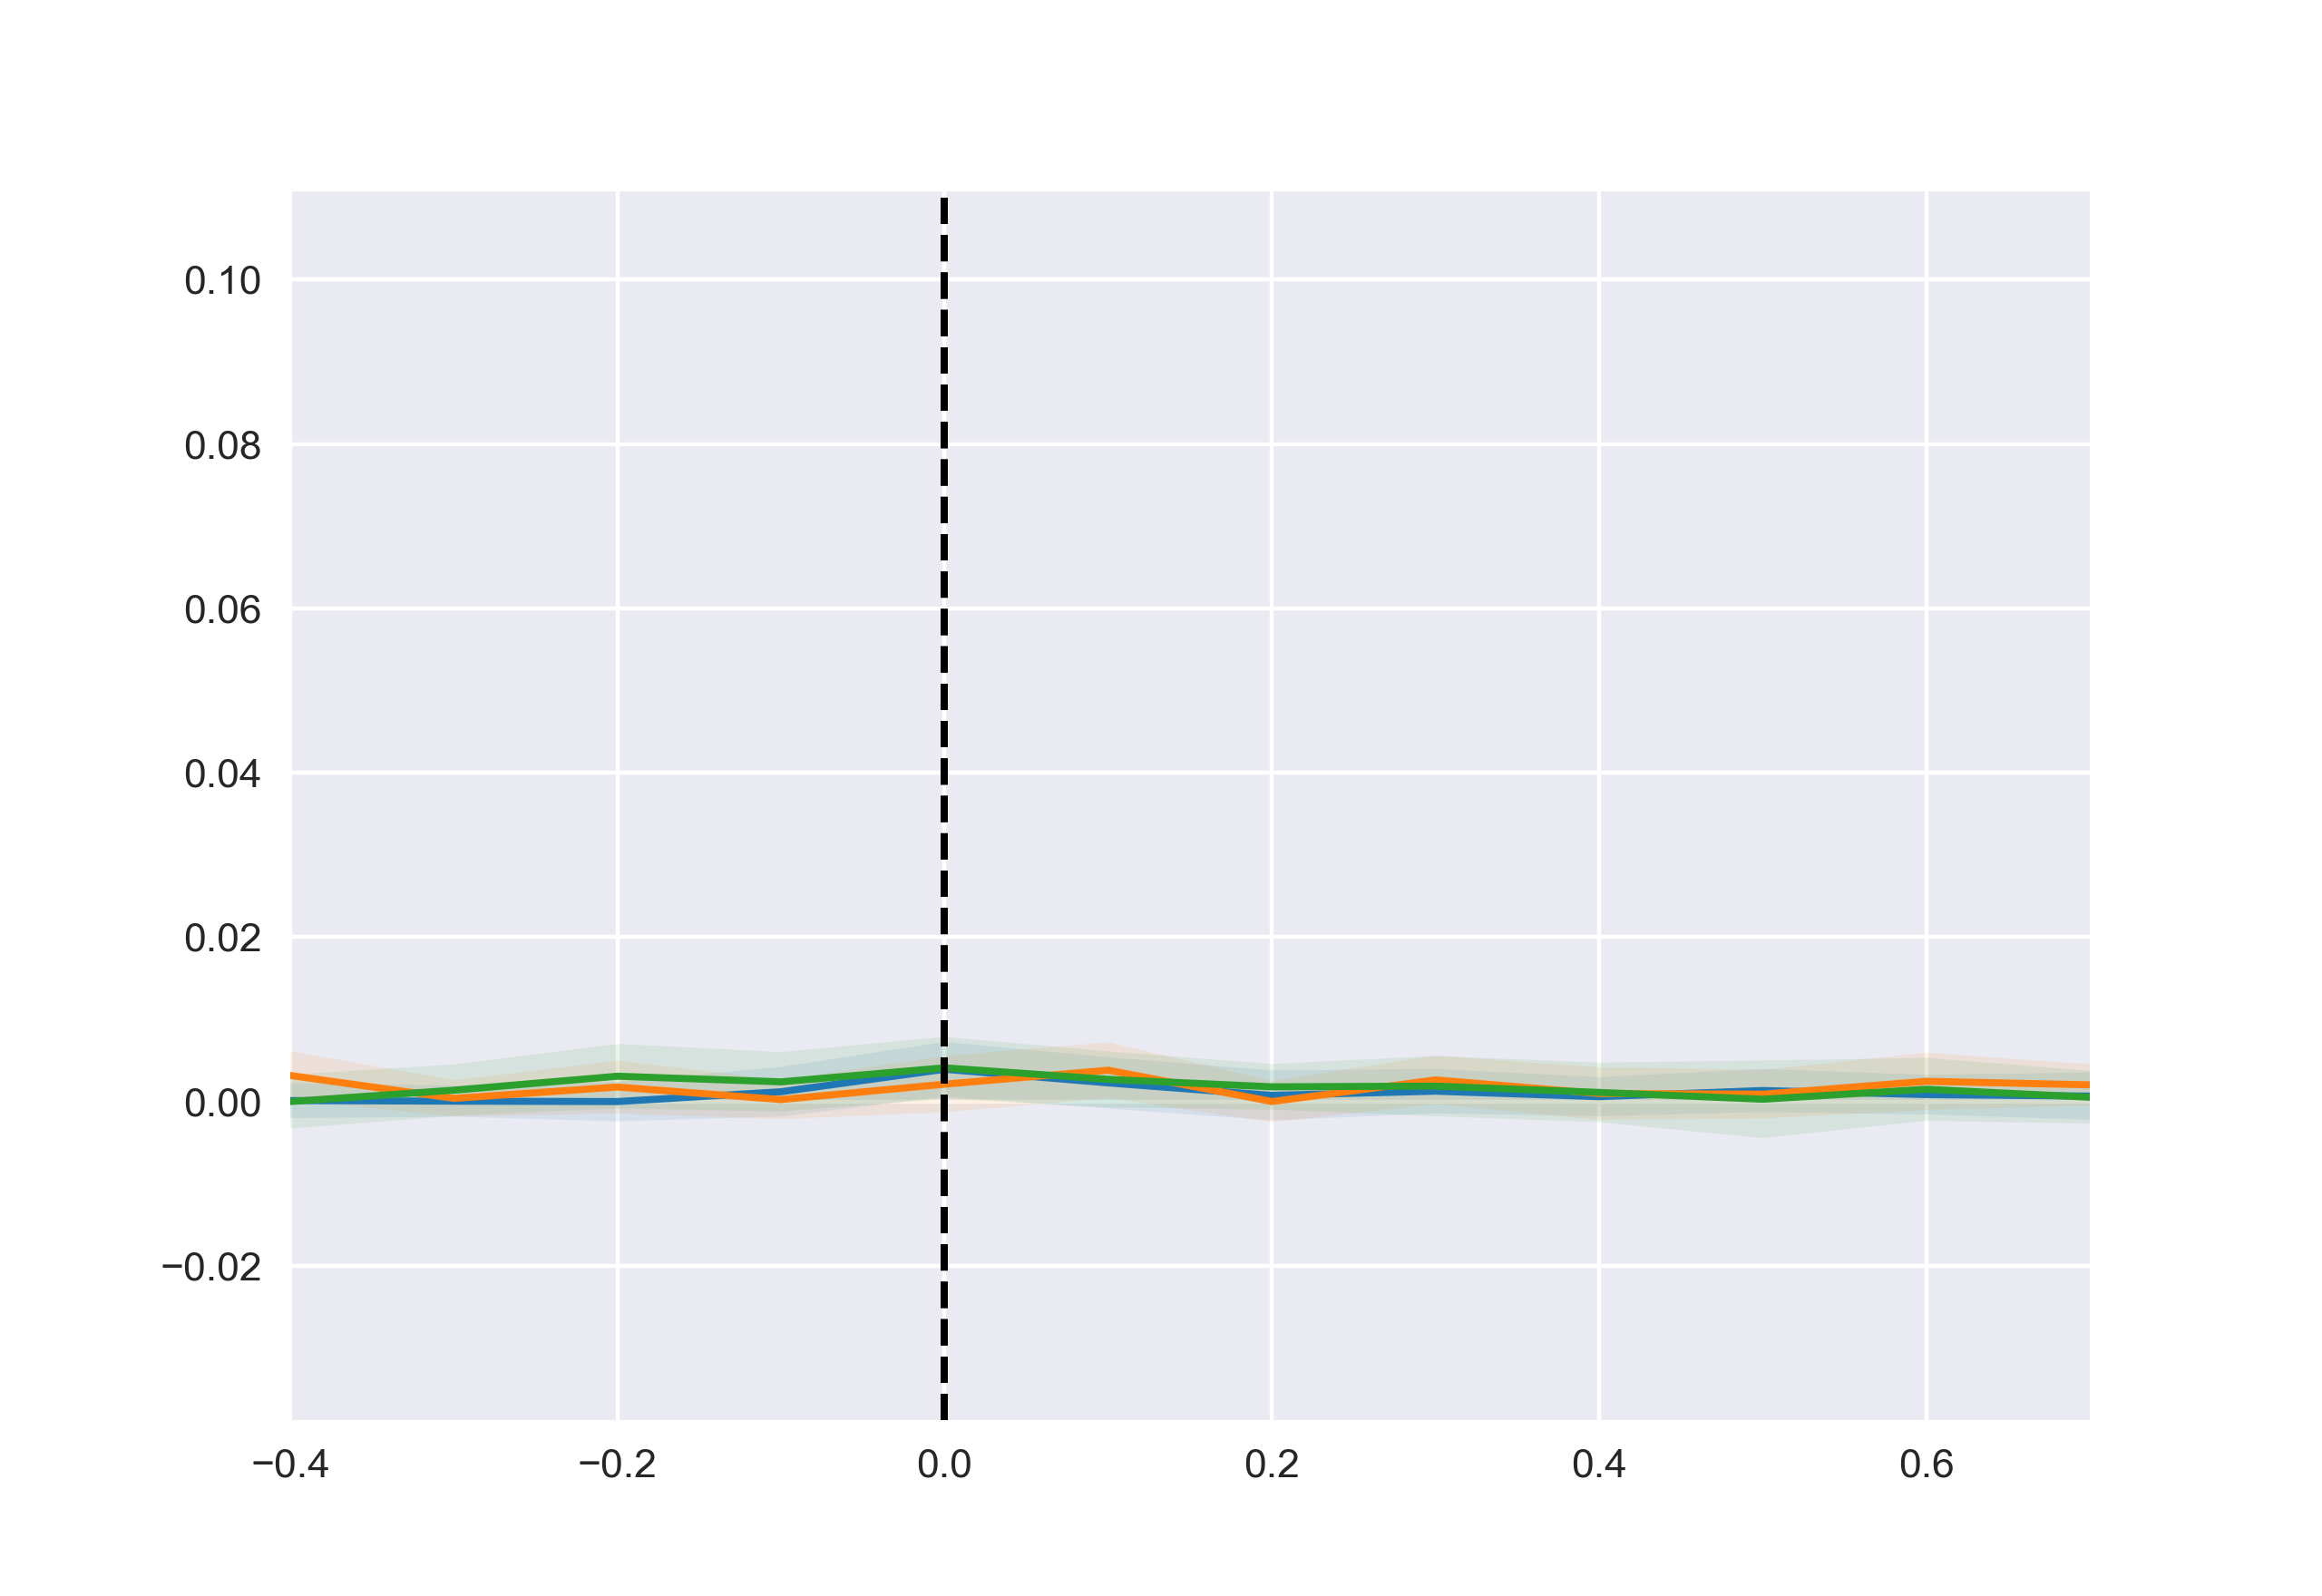

interactive(children=(Dropdown(description='roi', options=('L_caudalmiddlefrontal-L_cuneus', 'L_caudalmiddlefr…

In [175]:
conn_ud_subset = conn_ud.sel(roi=outList)

fig, ax=plt.subplots()
plot_conn(conn_ud_subset, interactive=True)

### 1.2.4 Increase the resolution

In [34]:
# define sliding windows
win_sample, mean_time = define_windows(
    times, slwin_len=0.5, slwin_step=0.05
)

# compute the connectivity
conn_ud = conn_dfc(hga, win_sample=win_sample, roi='channels', times='times')

# plot the result
plot_conn(conn_ud, interactive=True)

Defining temporal windows
    Definition of sliding windows (len=0.5, start=-0.5, stop=1.5, step=0.05)
    30 windows defined
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=False, demeaned=False)
Computing DFC between 36 pairs (gcrn=False)


  0%|          | Estimating DFC : 0/36 [00:00<?,       ?it/s]

interactive(children=(Dropdown(description='roi', options=("X'4-X'6", "X'4-X'8", "G'6-X'4", "G'7-X'4", "O'10-X…

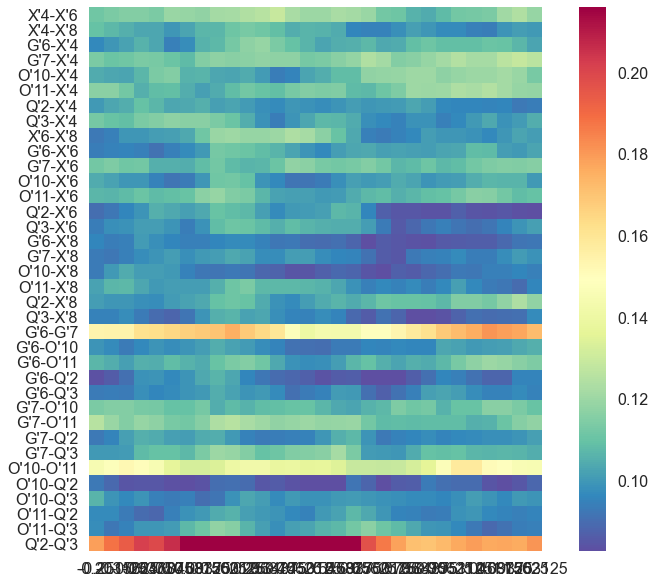

In [35]:
plot_conn(conn_ud, interactive=False)

# **2. Directed FC**
## 2.1 Directed and static FC

In [36]:
###############################################################################
dt = .75   # length 
lag = .25
t0 = 0.
###############################################################################

# load the data of a single subject
hga = load_ss(7)[0]
sfreq = hga.attrs['sfreq']

# time to sample conversion
dt_s = int(dt * sfreq)
lag_s = int(lag * sfreq)
t0_s = int(t0 * sfreq)

# compute the directed connectivity
conn_ds = conn_covgc(hga, dt_s, lag_s, t0_s, roi='channels', times='times',
                     n_jobs=-1)

WARNING | The ratio between the lag and dt is 35.41666666666667%. It's recommended to conserve this ratio less than 10-15%. Try with a step=3
Compute the  covgc (method=gc, normalised=False, n_pairs=36; n_windows=1, lag=16, dt=48, step=1)


  0%|          |  : 0/36 [00:00<?,       ?it/s]

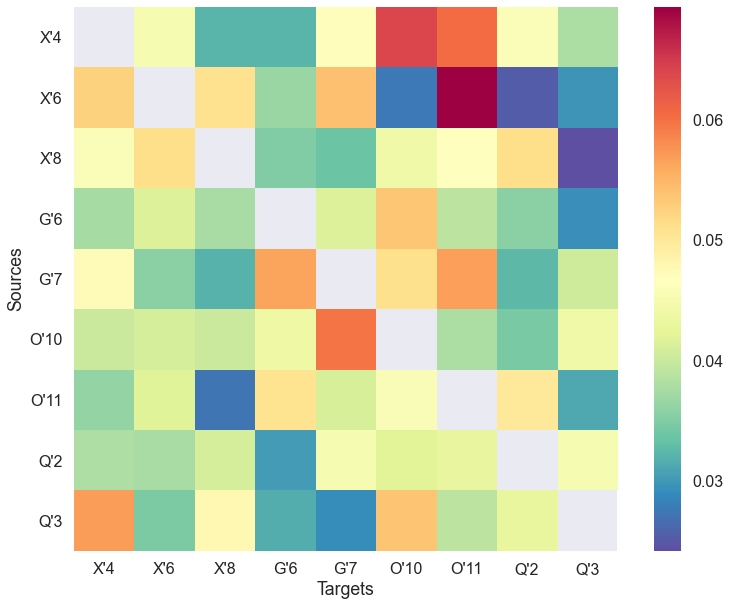

In [37]:
plot_conn(conn_ds)

## 2.1 Directed and dynamic FC _(bonus)_

<div class="alert alert-success"><p>

It's possible, but it's also computationaly very expenssive...
</p></div>

In [ ]:
# define several t0
t0_range = (np.linspace(-.25, 1., 20) * sfreq).astype(int)

# compute the dynamic for all of the t0
conn_dd = conn_covgc(hga, dt_s, lag_s, t0_range, roi='channels', times='times',
                     n_jobs=-1)

In [ ]:
plot_conn(conn_dd.copy(), interactive=True)

---
# **---- Test yourself ! ----**
## **1. Undirected FC between channels**
### 1.1 Load and prepare the data

<div class="alert alert-warning"><p>

**[Instructions]**

Load the data of subject #4. Then, define a variable `hga_s` which is going to contained the HGA of subject #4 during the **temporal period between [0, 1.5]s**
</p></div>

In [ ]:
# write your answer

### 1.2 Compute the static undirected FC

<div class="alert alert-warning"><p>

**[Instructions]**

Compute the static undirected connectivity (`conn_dfc`) on the variable `hga_s`. Save the output in a variable called `dfc`
</p></div>

In [ ]:
# write your answer

### 1.3 Plot the results

<div class="alert alert-warning"><p>

**[Instructions]**

Use the function `plot_conn` to plot the variable `dfc`. **What is the pair of contacts that are the more strongly connected?**
</p></div>

In [ ]:
# write your answer

### 1.4 Mean DFC across trials

<div class="alert alert-warning"><p>

**[Instructions]**

Take the mean of the DFC across trials and save the result in a variable called `dfc_m`
</p></div>

In [ ]:
# write your answer

### 1.5 Reshape the connectivity matrix

<div class="alert alert-warning"><p>

**[Instructions]**

Use the function `conn_reshape_undirected` on `dfc_m` to reshape the connectivity matrix (so that it becomes a 2D matrix)
</p></div>

In [ ]:
# write your answer

---
## 2. **Undirected FC between brain regions**
### 2.1 Data preparation

In the section above, we computed the connectivity between the channels of subject #4. In this section, we're going to compute the FC between **brain regions** of subject #2

<div class="alert alert-warning"><p>

**[Instructions]**

1. Load the data of subject #2 (`hga, anat, beh = load_ss(...)`)
2. Rename the dimension `channels` of the `hga` to be `roi`
3. From the `anat` output, get the list of brain regions (`list(anat['roi'])`) and fill the dimension `roi` of the variable `hga` with the name of the brain regions
</p></div>

In [ ]:
# write your answer

### 2.2 Mean HGA inside brain regions

<div class="alert alert-warning"><p>

**[Instructions]**

If you succeed in doing the previous part, your variable `hga` should now have a dimension `roi` with the name of the brain regions as a coordinate. Now, group by brain region name (`.groupby(...)`) and take the mean inside each brain region (`.mean(...)`). Save the result in a variable `hga_r`.
    
**How many brain regions the variable `hga_r` has?**
</p></div>

In [ ]:
# write your answer

### 2.3 Compute the FC between brain regions

<div class="alert alert-warning"><p>

**[Instructions]**

Comute the undirected FC (`conn_dfc`) on `hga_r` during the **temporal period [0; 1.5]s** and save the result in a variable `dfc_r`. **How many pairs of brain regions the variable `dfc_r` has?**
</p></div>

In [ ]:
# write your answer

### 2.4 Plot the results

<div class="alert alert-warning"><p>

**[Instructions]**

Use the function `plot_conn` to plot the variable `dfc_r`. **What is the pair of brain regions with the strongest connection?**
</p></div>

In [ ]:
# write your answer

### 2.5 Define sliding windows

<div class="alert alert-warning"><p>

**[Instructions]**

1. Get the time vector of the variable `hga_r` (`hga_r['times'].data`). Save the result in a variable called `times`
2. Use the function `define_windows` to define sliding windows of length 300ms (`slwin_len`) and with a step of 30ms (`slwin_step`). Save your sliding windows in a variable called `ws`
3 If you want, you can use the function `plot_windows` to plot your sliding windows
</p></div>

In [ ]:
# write your answer

### 2.6 Compute the dymanic undirected FC

<div class="alert alert-warning"><p>

**[Instructions]**

1. Now that you have your sliding windows in your variable `ws`, compute the dynamic functional connectivity on `hga_r` (`conn_dfc(..., win_sample=ws)`). Save the result in a variable called `dfc_us` 
2. Plot the result (`plot_conn(dfc_us, interactive=True)`).
    
**What is the pair of brain regions with the strongest connectivity AND at what time does it occurs?**
</p></div>

In [ ]:
# write your answer

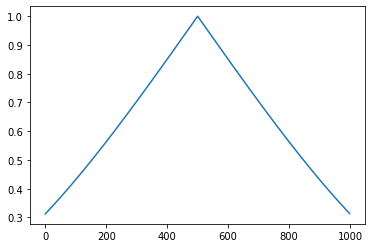

In [9]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

a = np.arange(1000)

plt.plot(signal.correlate(a, a, mode='same') / (np.sum(a ** 2)))

In [19]:
# create a vector
vector = np.random.normal(0,1,size=1000) 

# insert a signal into vector
vector[::50]+=10
ynorm = np.sum(vector**2)

# perform cross-correlation for all data points
output = np.correlate(vector,vector,mode='same') / ynorm

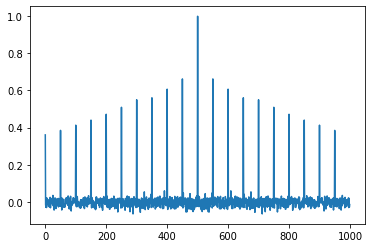

In [20]:
plt.plot(output)

In [16]:
output

array([3048.49366075])